In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['font.size'] = 8
#plt.rcParams['figure.dpi'] = 100
from scipy.stats import norm, lognorm
from scipy.interpolate import interp1d
from scipy.optimize import newton

In [2]:
def interpolate_yield(terms, yields, T=20, time_step = 1/12):
    t = np.linspace(0, T, int(T/time_step)+1)
    interp = interp1d(terms, yields, bounds_error=False,
                      fill_value=(yields[0],yields[-1]), kind='cubic')
    y = interp(t) # Interpolated yields
    z = np.exp(-t*y) # Interpolated Zero rates
    return t,y,z

In [3]:
def get_instantaneous_fwd_rate(terms, zero_curve, T):
    interp = interp1d(terms, zero_curve, bounds_error=False,
                      fill_value='extrapolate', kind='cubic')
    value1 = interp(T-0.001)
    value2 = interp(T+0.001)
    return -(np.log(value2)-np.log(value1))/0.002

In [4]:
def to_int(x):
    '''Function used to transform either floats or arrays of floats to int'''
    if type(x) == np.ndarray:
        x_int = (x).astype(int)
    elif type(x) == float:
        x_int = int(x)
    else:
        x_int = int(x)
    return x_int
    
def B(s,t):
    return (1-np.exp(-a*(t-s)))/a

def A_MC(s,t):
    '''A function used for pricing with x
    It does not include the factor P(0,t)/P(0,s) '''
    A = np.exp(-vol**2/(4*a) * B(s,t)**2*(1-np.exp(-2*a*s))
                -vol**2/(2*a**2)*B(s,t)*(1-np.exp(-a*s))**2)
    return A

def A(s,t):
    '''A function used for pricing with r'''
    A = z[to_int(t*nt)]/z[to_int(s*nt)]*np.exp(B(s,t)*fwd_rates[int(s*nt)]
            -vol**2/(4*a**3)*(np.exp(-a*t)-np.exp(-a*s))**2*(np.exp(2*a*s)-1))
    return A


def P(s,t,r):
    return A(s,t)*np.exp(-B(s,t)*r)

def P_MC(s,t,x):
    return z[to_int(t*nt)]/z[to_int(s*nt)]*A_MC(s,t)*np.exp(-B(s,t)*x)

# Pricing European Swaption

Exercise 31.19 of Hull is reproduced with three different methods.

Value 1 x 4, 2 x 3, 3 x 2, and 4 x 1 European swap
options to receive fixed and pay floating. Assume that the 1-, 2-, 3-, 4-, and 5-year
interest rates are 6%, 5.5%, 6%, 6.5%, and 7%, respectively. The payment frequency on
the swap is semiannual and the fixed rate is 6% per annum with semiannual compounding. Use the Hull–White model with $a = 3%$ and $\sigma = 1%$. (Calculate the volatility
implied by Black’s model for each option)

Solution: The option prices are 0.1302, 0.0814, 0.0580, and 0.0274. The implied Black volatilities are 
14.28%, 13.64%, 13.24%, and 12.81%

In [5]:
terms = np.array([1,2,3,4,5])
yields = np.array([6,5.5,6,6.5,7])/100
dfs = np.exp(-yields*terms)

a = 0.03
vol = 0.01
R = 0.06 #per annnum 
N = 100 #nominal
nt = 100 #Steps used per year for the interpolation and MC simulation
ti,y,z = interpolate_yield(terms,yields, T = 7,time_step=1/nt)
fwd_rates = get_instantaneous_fwd_rate(ti,z,ti)


## The interest rate process
Before we can value any derivative we need to understand the process that drives the interest rate. For this we assume the Hull-white short rate model. The short rate model is given by
$ dr(t) = (\theta(t) -a r(t))dt + \sigma dW(t)$
Skipping some steps (all explained in *Interst Rate Syllabus*) we arrive at the price of the a zero-coupon bond $P(s,t)$ which is fitted to the current market.
$$
\begin{aligned}
P(s, t) &=A(s, t) e^{-B(s, t) r(s)} \\
A(s, t) &=\frac{P^M(0, t)}{P^M(0, s)} \exp \left\{B(s, t) f^M(0, s)-\frac{\sigma^2}{4 a} B^2(s, t)\left(1-e^{-2 a s}\right)\right\} \\
B(s, t) &=\frac{1}{a}\left(1-e^{a(s-t)}\right)
\end{aligned}
$$
Here $P^M(0, t)$ is the bond price of the current market and $f^M(0, s)$ is the forward rate given by $f(t, T) = \frac{\partial logP(t,T)}{\partial T}$
In some cases we will use these equations and to calculate the forward rate we can interpolate the zcb curve and use a discrete derivative as approximation.

Another method is to consider a shifted short rate process $x(t) = r(t) - \alpha(t)$. If $\alpha(t)$ is chosen correctly it can make the short rate process $x(t)$ mean free (not dependent on $\theta(t)$ and thus not dependent on the forward rate. The process is given by $dx(t) = -ax(t)dt + \sigma dW(t)$. This makes simulation with monte carlo methods easier. The coupon bond is now calculated by
$$
P(s,t) =\frac{P^M(0, t)}{P^M(0, s)} \exp \left\{-\frac{\sigma^2}{4 a} B^2(s, t)\left(1-e^{-2 as}\right)-\frac{\sigma^2}{2a^2} B(s, t)\left(1-e^{-a s}\right)^2-B(s, t) x(s)\right\}
$$
and the process x(s) has the following normal distribution
$$ x(s) \sim N\left(0, \frac{\sigma^2}{2a}(1-\exp(-2as))\right)$$

In order to help us calculate expectation values we change from the risk neutral measure Q  to a T-forward measure. For a payoff $V(T)$ and money making account $M(t)$ it holds that
$$
V(t) = M(t) \mathrm{E}^Q\left(\frac{V(T)}{M(T)}|\mathcal{F}_t\right)
$$
Changing the numérair to a zero-coupon bond maturing at time $T$ as the bank-account. Since $P(T,T)=1$ we get the T-forward measure:
$$
V(t) = P(t,T) \mathrm{E}^T\left(\frac{V(T)}{P(T,T)}|\mathcal{F}_t\right) = P(t,T) \mathrm{E}^T\left(V(T)|\mathcal{F}_t\right)
$$
Under this change of measure (from Q risk neutral to T-forward ), the drift of the x(t)-process will also change. This equals to the volatiliy of $\frac{P(t,T)}{M(t)}$.
This is given by Girsanov theorem. The derivation here is adapted from *Damiano Brigo & Fabio Mercurio: Interest Rate Models –Theory and Practice -With Smile, Inflation and Credit*

Consider the dynamics of a more general $x(t)$ under both meausres $Q^q$ (risk neutral) and $Q^T$ (T-forward);
$$
dx(t) = \mu_t^q dt + \sigma_t dW^q_t\\
dx(t) = \mu_t^T dt + \sigma_t dW^T_t
$$
In this case we know $\mu_t^q = -ax(t)$ and want to find what $\mu_t^T$ is. 
The change of numeraire is done with the Radon-Nikodym derivative between $Q^q$ (risk neutral) and $Q^T$ (T-forward). Girsanov's theorem gives an expression for this derivative
$$
\zeta_t = \frac{dQ^T}{dQ^q}|_{\mathcal{F}_t} = \exp\left(-\frac{1}{2}\int_0^t\frac{1}{\sigma^2}(\mu_s^T - \mu_s^q)^2ds + \int_0^t\frac{1}{\sigma}(\mu_s^T - \mu_s^q)dW^q \right)
$$
The process $\zeta_t$ defines the measure $dQ^T$ given the measure $dQ^q$. Because of its form we see that $\zeta_t$ is an exponential martingale. For $\alpha_t = \frac{1}{\sigma}(\mu_t^T - \mu_t^q)$ we can write $d\zeta_t = \alpha_t \zeta_t dW_t^q$ (this can be verified by using Itô's lemma). Since $\frac{dQ^T}{dQ^q}$ is the Radon-Nikodym derivative and we know the numeraire associated to each measure we can write
$$
 \zeta_T = \frac{dQ^T}{dQ^q}|_{\mathcal{F}_T} = \frac{M(0)P(T,T)}{P(0,T)M(T)}
$$
As from above we know that $\zeta_t$ is a martingale under the process $dW^q$, therfore the process P/M is as well. This gives that $\zeta_t = E^{Q^q}[\zeta_T] = E^{Q^q}[\frac{M(0)P(T,T)}{P(0,T)M(T)}] = \frac{M(0)P(t,T)}{P(0,T)M(t)}$
To find the differential form we use Itô's lemma:
$$
d\zeta_t = \frac{M(t)}{P(0,T)}d\frac{P(t,T)}{M(t)} = ... dt + \frac{M(t)}{P(0,T)}\frac{\partial \frac{P(t,T)}{M(t)}}{\partial x(t)} dx(t) = -\sigma B(t,T)\frac{M(0)P(t,T)}{P(0,T)M(t)} dW(t)
$$
Since we know that this process is a martingale it has no drift and there is no need to calculate it. 
Comparing the two expressions for $d\zeta_t$ we find that
$$
\alpha_t = -\sigma B(t,T)
$$
Therefore we obtain that $\mu_t^T = \mu_t^Q - \sigma^2B(t,T)$. We find that the drift change therfore equals $ -\sigma^2B(t,T)$.

The process for $x(t)$ under $Q^T$ is now given by
$$
dx(t) = -ax(t)dt -\sigma^2 B(t,T)dt + \sigma dW^T_t
$$
To solve for the integral form we use Itô's lemma on $f(t,x)=xe^{at}$
$$
df(t,x) = \left(\frac{\partial f}{\partial t} - ax\frac{\partial f}{\partial x} + \frac{\sigma^2}{2}\frac{\partial^2 f}{\partial x^2}\right)dt + \sigma \frac{\partial f}{\partial x}dW^T_t \\
df(t,x) = -\sigma^2 B(t,T) e^{at}dt + \sigma e^{at}dW_t^T 
$$
Integrating both sides and rewriting it gives
$$
x(T)e^{aT} - x{t}e^{at} = -\sigma^2\int_t^T B(s,T)e^{as}ds + \sigma \int_t^T e^{as}dW_s^T \\
x(T) = x(t)e^{-a(T-t)}  -\sigma^2\int_t^T B(s,T)e^{-a(T-s)}ds + \sigma \int_t^T e^{-a(T-s)}dW_s^T
$$
where $\int_t^T B(s,T)e^{-a(T-s)}ds = \frac{1}{2}B(t,T)^2$. This term is the additional drift when switching to the T-forward measure. We can use this process to simulate x(t) and take the expected value and discounting it afterwards instead of needing to have the discounting inside the expectectation value. (You can see this as having removed the correlation between x(t) and P(t,T). ) The distribution of $x(s)$ under this measure is then given by:
$$ x(s) \sim N\left(- \frac{\sigma^2}{2}B(0,s)^2, \frac{\sigma^2}{2a}(1-\exp(-2as))\right)$$

As an example I have simulated a few paths of the process x(t) under the T-forward measure and the accompaning ZCB price. 

Text(0.5, 1.0, 'Discount factor')

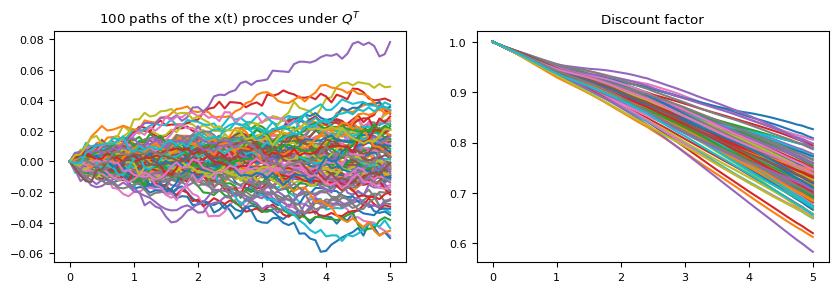

In [6]:
def Simulate_MC(s, nsim, Dt=1, nt=365):
    dt = 1/nt
    
    #Define quantities for a small step dt 
    std_x_dt = np.sqrt(vol**2/(2*a)*(1-np.exp(-2*a*dt)))
    B_dt = B(0,dt) 
    drift_x_dt =  - vol**2/2*B_dt**2 #For T-forward measure
    xt = 0
    
    #only store the value of xt and df on at the times when they are needed
    #This can be yearly, monthly or any other period dependent on Dt
    num_periods = int(s/Dt)
    steps_per_period = int(nt*Dt)
    x = [np.zeros(nsim)]
    df = [np.ones(nsim)]
    d0 = 1
    for i in range(num_periods):
        for j in range(0, steps_per_period):
            k = i*steps_per_period + j
            d_m = P_MC(ti[k],ti[k+1],xt)
            #d_m = z[k+1]/z[k]* A(ti[k],ti[k+1])*np.exp(-B_dt*xt)
            d0 = d0*d_m
            xt = xt*np.exp(-a*dt) + drift_x_dt - np.random.normal(size=nsim)*std_x_dt
        x.append(xt)
        df.append(d0)
    x = np.array(x)
    df = np.array(df)

    return x,df

nsim = 100
Dt = 1/12 #Monthly
t= 5 # years
x, df= Simulate_MC(t, nsim,Dt=Dt, nt=nt)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,3))
ax1.plot(np.arange(0,t+Dt,Dt),x)
ax2.plot(np.arange(0,t+Dt,Dt),df)
ax1.set_title(r'100 paths of the x(t) procces under $Q^T$')
ax2.set_title('Discount factor')

### Pricing European Call on a ZCB
Before we go to the pricing of a swaption we need to know how to price a call option on a zero coupon bond (ZCB).
Consider the price at $t=t$ of an option maturing at $T_0$ on a bond lasting from $T_0$ till $T_j$. The analytical option on a ZCB under the Hull-white 1 factor model is given by:
$$ZBO(t,T_0,T_j) = P(t,T_j)N(h) - K P(t,T_0) N(h-\sigma_p)$$
with 
$$
h = \frac{1}{\sigma_p} \ln \left(\frac{P\left(t, T_j\right)}{K P\left(t, T_0\right)}\right)+\frac{\sigma_p}{2}
$$
$$
\sigma_p =\sigma \sqrt{\frac{1- e^\left(-2 \alpha\left(T_0-t\right)\right)}{2 \alpha}} B\left(T_0, T_j\right),
$$
Derivation is in *Hull JC: Options Futures and Other Derivatives (Technical Note 31)*


To price an European call on a ZCB with monte carlo simulations we can simply take the average of multiple paths of x(t) 
$$
V(t) = P^M(t,T_0) \sum_i^{N_{sim}}[(A(T_0,T_j)e^{-B(T_0,T_j)x^i(T_0)} - K)^+]
$$
Note that the discounting $P^M(t,T_0) $ can be taken outside the average since we simulate x(t) under the T-forward measure.

In [7]:
def ZBO_exact(s,t, K, L=1, Call=True):
    P0t = z[to_int(t*nt)] #
    P0s = z[to_int(s*nt)] 

    sigma_p = vol/a * (1-np.exp(-(t-s)*a))*np.sqrt((1-np.exp(-2*a*s))/(2*a))
    h = 1/sigma_p *np.log((L*P0t)/(K*P0s)) + sigma_p/2
    
    if Call:
        price = L*P0t*norm.cdf(h) - K *P0s* norm.cdf(h-sigma_p) 
    if not Call: #put
        price = K *P0s* norm.cdf(-h+sigma_p) - L*P0t*norm.cdf(-h)
    return price


def PDF_x(s, N=1024, i =6):
    std_x = np.sqrt(vol**2/(2*a)*(1-np.exp(-2*a*s)))
    mu_x = (-vol**2/2*B(0,s)**2) #Adjustedment for numeraire change
    x = np.linspace(mu_x-i*std_x,mu_x+i*std_x,N)
    p = norm.pdf(x,mu_x,std_x)
    p = p/np.sum(p)
    return x, p 

s,t= 1,4
K =0.81

# With analytical pricing formula
exact_price = ZBO_exact(1,4,0.81, L=1, Call=True)*100
print(exact_price)

#With discretizing the pdf of x(s)
x,px = PDF_x(s)
p = P_MC(s,t,x)
PDF_price = np.sum(px*(np.maximum(p - K,0)))*z[to_int(s*nt)] *100
print(PDF_price)

# With Monte Carlo simulation of x(t) till t=s
x, df= Simulate_MC(s, 10**5,Dt=Dt, nt=nt)
p = P_MC(s,t,x[int(s/Dt)])
MC_price = np.mean((np.maximum(p - K,0)))*z[to_int(s*nt)] *100
print(MC_price)

1.3373539130916046
1.3373575640333428
1.3087512905311693


## Pricing European Swaption

Exercise 31.19 of Hull is reproduced with three different methods.

Value 1 x 4, 2 x 3, 3 x 2, and 4 x 1 European swap
options to receive fixed and pay floating. Assume that the 1-, 2-, 3-, 4-, and 5-year
interest rates are 6%, 5.5%, 6%, 6.5%, and 7%, respectively. The payment frequency on
the swap is semiannual and the fixed rate is 6% per annum with semiannual compounding. Use the Hull–White model with $a = 3%$ and $\sigma = 1%$. (Calculate the volatility
implied by Black’s model for each option)

Solution: The option prices are 0.1302, 0.0814, 0.0580, and 0.0274. The implied Black volatilities are 
14.28%, 13.64%, 13.24%, and 12.81%

In [8]:
#Set the parameters for the option 

Dt = 1/2 #semi annual compounding
T0 = 1 # start date
TM = 5 # End date

#The data at which rates are exchanged
T_range = np.arange(T0+Dt,TM+Dt,Dt)

# payoffs of the coupon bearing bond used as replication
c = np.tile(N*Dt*R,len(T_range)) 
c[-1] = N*(1+Dt*R)

### Analytical solution
The analytical formula for an swaption is derived as follows
Consider
- A set of times where $t < T_0 < T_1 < .. < T_m$. Where $\Delta t = T_{i+1}-T_{i}$ is assumed constant.

- The notional amount is N

- The fixed rate is R

At each $T_j \in {T_0,... T_m}$ one exchanges a fixed rate against the floating rate. The fixed leg pays $N\cdot R \cdot \Delta t$ at each $T_j$ and recieves floating: $N\cdot L(T_{i-1},T_i)\cdot \Delta t$. Following the derivation in the *Interest Rate Syllabus* we obtain the value of an Interest rate swap of
$$V(t) = N\left( P(t,T_0) - P(t,T_m) - R\sum_{i=1}^m P(t,T_i)\Delta t\right) $$
We can rewrite this by defining $c_j = N R\Delta t$ for $j\in \{0,1,..m-1\} $ and $c_m = N(1+R\Delta t)$. The swaption value can now be expressed by taking the maximum of the swap payoff and 0. 
Since $P(T_0, T_0) = 1$, the payoff of an swaption at $t=T_0$ is given by value of the receiver swaption expiring at time $T_0$ is given by
$$RS(T_0) = \left(\sum_{j=1}^m c_j P(T_0,T_j) - N\right)^+$$
This is equal to an option on a Coupon-bearing bond with strike price N:
$$RS(T_0) = \left(CB(T_0,T_m) - N\right)^+$$

In the Hull-white model we can calculate the zero coupon bond price at t maturing at T as: $P(t,T,r_t) = A(t,T) \exp(-B(t,T)r(t))$
The trick is to convert the positive part of the sum to the sum of positive parts. This is done with the Jamshidian decomposition.
Find an $r^*$ such that 
$$\sum_{j=1}^m c_j K_j = N, \quad \text{where} \quad K_j = P(T_0,T_j, r^*)$$
This can be solved numerically and we use the Newton-Raphson algorithm for this.
For the decomposition to hold we need: $\frac{\partial P(t,T,r_t)}{\partial r_t} < 0$. One can show that for both cases $r_{T0} < r* $ and $r_{T0} > r* $ the decomposition holds.
Thus we obtain:
$$ RS(T_0) =  \sum_{j=1}^m c_j (P(T_0,T_j,r_{T_0}) - K_j)^+ $$
This is then the sum of m payoffs all being exercised at the same time $T_0$. Therefore we can discount them all to $t$ resulting in European call options on zero coupon bonds with strikes $K_j$

*For an extensive derivation see: https://open.uct.ac.za/bitstream/handle/11427/29514/thesis_com_2018_masutha_ndinae_nico.pdf?isAllowed=y&sequence=1*

In [9]:
#Find the r* using the newton-raphson algorithm
def f(x):
    #Define function for the solver to use.
    summant = c*A(T0,T_range)*np.exp(-B(T0,T_range)*x)
    return np.sum(summant)-N

r_star = newton(f,0.1)
print('r* = ', r_star)

#The K_j are given by:
K_range = A(T0,T_range)*np.exp(-B(T0,T_range)*r_star)

#The summation of all ZCB options
swaption_exact = 0
for j, Tj in enumerate(T_range):
    Kj = K_range[j]
    swaption_exact +=c[j]*ZBO_exact(T0,Tj,Kj)
    #print(Call_ZCB_exact(T0,Tj,Kj))
print()
print(swaption_exact)

r* =  0.03965316291619671

0.13244925365133062


### Solving with Monte Carlo simulation
To estimate the swaption price with Monte Carlo. Simulate $N_{sim}$ paths of the interst rate till time $T_0$.
This can be done by simulating the process x(t) and adjusting the A and B functions for the Coupon bond pricing. 
Then the payoff can be calculated by summing all payoff and then taking the average of all payoffs and discoutning.
$$RS(t) =\frac{1}{N_{sim}} Df(T_0) \sum_{i=1}^{N_{sim}} \left(\sum_{j=1}^m c_j A(T_0,T_j)\exp{\left((-B(T_0,T_j)x^i(T_0)\right)} - N\right)^+$$

In [10]:
##### Monte Carlo
nsim = 10**5
x, df= Simulate_MC(T0, nsim, Dt=Dt, nt=nt)

payoff = 0
for j,Tj in enumerate(T_range):
    payoff +=  c[j]*P_MC(T0,Tj,x[int(T0/Dt)])
payoff -= N 
swaption_MC = np.mean(np.maximum(payoff,0))*z[int(T0*nt)] 
print(swaption_MC)

0.13022682958071516


### Solving with calculating the PDF for x(s)
Instead of simulating paths of the interest rate we can also calculate that PDF of the interest rate at $T_0$ directly and use this to calculate the swap option price.
First the PDF of the interest rate is calculated. This is given by
$$ x(s) \sim N\left(-\frac{\sigma^2}{2}B(0,s)^2, \frac{\sigma^2}{2a}(1-\exp(-2as))\right)$$
Once the PDF is sufficiently well approximated (number of discrete points and range) the option price can be accurately calculated by either using the Jamshidian decomposition and calculating the option price of multiple ZCBs. Or by using the same method as MC and caculating the total payoff before taking the average.
$$RS(t) = Df(T_0) \sum_{x=low}^{high} p_x \left(\sum_{j=1}^m c_j A(T_0,T_j)\exp{\left((-B(T_0,T_j)x(T_0)\right)} - N\right)^+$$


In [11]:
##### PDF with once PDF
swaption_PDF_x = 0

x, p_x = PDF_x(T0, N=2**14, i =10)
for j,Tj in enumerate(T_range):
    p = P_MC(T0,Tj,x)
    Kj = K_range[j]
    price = np.sum(p_x*(np.maximum(p - Kj,0)))*z[to_int(T0*nt)]
    swaption_PDF_x += c[j]*price
    #print(price)
#print()
print(swaption_PDF_x)

0.1324492536951547


In [12]:
##### PDF without r_star
payoff = 0

x,px = PDF_x(T0, N=10000)
for j,Tj in enumerate(T_range):
    p = P_MC(T0,Tj,x)        
    payoff += c[j]*p
payoff += -N   
swaption_PDF_x = np.sum(px*(np.maximum(payoff,0)))*z[to_int(T0*nt)]
print(swaption_PDF_x)

0.1324492429529488


### Solving with the PDF for $P(T_0,T_j)$
Since we know the distribution of $P(T_0,T_j)$ it can also be directly used in the calculation instead of using the pdf of $x(t)$. The drawback of this method is that for each exchange period $T_j$ a different PDF needs to be calculated.
Since $P(T_0,T_j) = A(T_0,T_j)e^(-B(T_0,T_j)x(T_0))$ the distribution of $P(T_0,T_j)$ is Log normal (x is normal).
Let $\mu_x =  -\frac{\sigma^2}{2}B(0,s)^2$  and $\sigma_x =  \sqrt{\frac{\sigma^2}{2a}(1-\exp(-2as))}$ then the distribution of $P(T_0,T_j)$ is given by
$$ P(T_0,T_j) \sim Lognormal \left( \log(A(T_0,T_j))- \mu_x B(T_0,T_j)  ,\   (\sigma_x B(T_0,T_j))^2 \right)$$
Once the PDF is sufficiently well approximated (number of discrete points and range) the option price can be accurately calculated by either using the Jamshidian decomposition and calculating the option price of multiple ZCBs. Or by using the same method as MC and caculating the total payoff before taking the average.
$$RS(t) = Df(T_0) \sum_{x=low}^{high} p_x \left(\sum_{j=1}^m c_j A(T_0,T_j)\exp{\left((-B(T_0,T_j)x(T_0)\right)} - N\right)^+$$


In [13]:
def PDF_P(s,t,N=1024,i=6):
    std_x = np.sqrt(vol**2/(2*a)*(1-np.exp(-2*a*s)))
    mu_x = (-vol**2/2*B(0,s)**2) #Adjustedment for numeraire change
    
    std_y = std_x*B(s,t)
    mu_y =  np.log(z[int(nt*t)]/z[int(nt*s)]*A_MC(s,t)) - mu_x*B(s,t) 

    mean = np.exp(mu_y+std_y**2/2)
    sigma = np.sqrt((np.exp(std_y**2)-1)*np.exp(2*mu_y+std_y**2))
    p = np.linspace(mean-i*sigma,mean+i*sigma,N)
    y = lognorm.pdf(p,s=std_y, scale=np.exp(mu_y))
    y_norm = y/np.sum(y)
    return p, y_norm

In [14]:
swaption_PDF_P=0
for j,Tj in enumerate(T_range):
    p, p_prob = PDF_P(T0,Tj)
    Kj = K_range[j]
    price = np.sum(p_prob*(np.maximum(p - Kj,0)))*z[to_int(T0*nt)]
    swaption_PDF_P += c[j]*price
    #print(price)
#print()
print(swaption_PDF_P)

0.13245104948114483


### Using a Taylor approximation
Finally, with the idea of implementing the pricing of a Swaption on a Quantum computer we can also approximate the exponent used to calculate the bond price $P(T_0,T_j)$. For this we then only need the pdf of $x(T_0)$ and some multiplication operations instead of exponentation. The taylor approximation is
$$Ae^Bx =  A(1 + Bx + \frac{(Bx)^2}{2} + \frac{(Bx)^3}{6} + ...)$$
It should be investigated how many terms are to be included. But with first trails it shows that either including till $\frac{(Bx)^2}{2}$ or $\frac{(Bx)^3}{6}$ is sufficient. This depends on the number of exchanges, the maturity and the model parameters ($a$ and $\sigma$).

In [15]:
# Use Taylor to approximate Ae^Bx = A(1+Bx + (Bx)^2/2 ... )
swaption_Taylor=0
x, px_norm = PDF_x(T0)

for j,Tj in enumerate(T_range):
    AA =z[int(nt*Tj)]/z[int(nt*T0)]*A_MC(T0,Tj)
    BB = -B(T0,Tj)
    p1 = AA*(1+BB*x+(BB*x)**2/2 )#+(BB*x)**3/6)
    Kj = K_range[j]
    price = np.sum(px_norm*(np.maximum(p1 - Kj,0)))*z[to_int(T0*nt)]
    swaption_Taylor += c[j]*price
    #print(price)
#print()
print(swaption_Taylor)

0.13203921460679882


In [16]:
# In summary we have
print('Exact price:    ', swaption_exact)
print('Monte Carlo:    ', swaption_MC)
print('Discrete PDF x: ', swaption_PDF_x)
print('Discrete PDF P: ', swaption_PDF_P)
print('Taylor approx:  ', swaption_Taylor)

Exact price:     0.13244925365133062
Monte Carlo:     0.13022682958071516
Discrete PDF x:  0.1324492429529488
Discrete PDF P:  0.13245104948114483
Taylor approx:   0.13203921460679882
